In [1]:
%matplotlib inline
import sys
%cd /home/jnyborg/git/gdd


import random
from dataset import PixelSetData
from utils import label_utils
from collections import Counter, defaultdict
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange, tqdm
from datetime import datetime

/home/jnyborg/git/gdd


In [12]:
classes = label_utils.get_classes('denmark', 'france', 'austria', combine_spring_and_winter=False, method=set.union)
print(classes)
classes.remove('spring_rapeseed')
classes.remove('spring_rye')
classes.remove('spring_triticale')
#classes = sorted(['corn', 'horsebeans', 'meadow', 'spring_peas', 'spring_barley', 'unknown', 'winter_barley', 'winter_rapeseed', 'winter_triticale', 'winter_wheat'])


dataset_dk = PixelSetData('/media/data/timematch_data', 'denmark/32VNH/2017', classes=classes)
dataset_fr1 = PixelSetData('/media/data/timematch_data', 'france/30TXT/2017', classes=classes)
#dataset_fr2 = PixelSetData('/media/data/timematch_data', 'france/31TCJ/2017', classes=classes)
#dataset_aus = PixelSetData('/media/data/timematch_data', 'austria/33UVP/2017', classes=classes)

print(classes)

['corn', 'horsebeans', 'meadow', 'spring_barley', 'spring_oat', 'spring_peas', 'spring_rapeseed', 'spring_rye', 'spring_triticale', 'spring_wheat', 'sunflowers', 'unknown', 'winter_barley', 'winter_oat', 'winter_peas', 'winter_rapeseed', 'winter_rye', 'winter_triticale', 'winter_wheat']
['corn', 'horsebeans', 'meadow', 'spring_barley', 'spring_oat', 'spring_peas', 'spring_wheat', 'sunflowers', 'unknown', 'winter_barley', 'winter_oat', 'winter_peas', 'winter_rapeseed', 'winter_rye', 'winter_triticale', 'winter_wheat']


In [3]:
labels_dk = dataset_dk.get_labels().tolist()
labels_fr1 = dataset_fr1.get_labels().tolist()
#labels_fr2 = dataset_fr2.get_labels().tolist()
#labels_aus = dataset_aus.get_labels().tolist()
min_freq = 200



rows = []
for tile, labels in [('32VNH', labels_dk), ('30TXT', labels_fr1)]:#, ('31TCJ', labels_fr2), ('33UVP', labels_aus)]:
    freq = np.bincount(labels, minlength=len(classes))
    for cls_idx, freq in enumerate(freq):
        rows.append((tile, classes[cls_idx], freq))

labels_df = pd.DataFrame(data=rows, columns=['tile', 'class', 'count'])



# Class balance

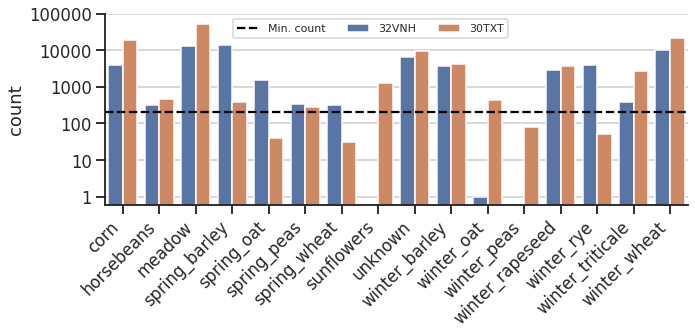

In [4]:
sns.set_theme(style="ticks")
sns.set_context('talk')

plt.figure(figsize=(10,5))
g = sns.barplot(data=labels_df, x="class", y='count', hue="tile")
g.set_yscale('log')
ticks = [1, 10, 100, 1000, 10000, 100000]
g.set_yticks(ticks)
g.set_yticklabels(ticks)
sns.despine()
plt.xticks(rotation=45, ha='right')
plt.axhline(y=min_freq, color='black', linestyle='--', label='Min. count')
plt.legend(bbox_to_anchor=(0.21, 1.0), ncol=5, fontsize=11)
plt.grid(axis='y')

plt.xlabel(None)
plt.tight_layout()
plt.savefig('class_distribution.pdf')


In [14]:
classes = label_utils.get_classes('denmark', 'france', 'austria', combine_spring_and_winter=False, method=set.union)

dataset_dk = PixelSetData('/media/data/timematch_l2a', 'denmark/32VNH/2017', classes=classes, with_extra=False)
dataset_fr = PixelSetData('/media/data/timematch_l2a', 'france/30TXT/2017', classes=classes, with_extra=False)
#dataset_dk = PixelSetData('/media/data/timematch_data', 'denmark/32VNH/2017', classes=classes, with_extra=False)
#dataset_fr = PixelSetData('/media/data/timematch_data', 'france/30TXT/2017', classes=classes, with_extra=False)

def get_ndvi_values(indices, dataset, country_name, max_examples=None):
    #rows = []
    ndvis = []
    doys = None
    total_pixels, total_cloudy = 0, 0
    if max_examples is not None:
        random.shuffle(indices)
        indices = indices[:max_examples]
    for image_idx in indices:
        sample = dataset[image_idx]
        pixels = sample['pixels'] / (2**16-1)
        if pixels.shape[1] == 11:
            cloud_mask = pixels[:, 10]
            no_cloud_mask = cloud_mask == 0  # (T, S)
            
            total_pixels += pixels.shape[2]
            total_cloudy += (cloud_mask > 0).sum(1)
            
            pixels = np.moveaxis(pixels, 1, 0)  # (T, C, S) -> (C, T, S)
            pixels = pixels * no_cloud_mask
            with np.errstate(divide='ignore', invalid='ignore'):  # if only clouds, set to NaN
                red = pixels[2, :].sum(1) / no_cloud_mask.sum(1)
                nir = pixels[3, :].sum(1) / no_cloud_mask.sum(1)
        else:
            red = pixels[:, 2].mean(1)
            nir = pixels[:, 3].mean(1)
            
        with np.errstate(divide='ignore', invalid='ignore'):  # if only clouds, set to NaN
            ndvi = (nir - red) / (nir + red)
        ndvis.append(ndvi)
    ndvis = np.array(ndvis)
    ndvis = np.nanmean(np.array(ndvis), axis=0)
    cloudy_pct = (total_cloudy / total_pixels)*100.0
    return ndvis, cloudy_pct


def plot_ndvi_values(crop_name, n=1000, max_cloudy_pct=80.0):
    if crop_name == 'all classes':
        samples_dk = list(range(len(dataset_dk)))
        samples_fr = list(range(len(dataset_fr)))
    else:
        samples_dk = (np.arange(len(dataset_dk))[dataset_dk.get_labels() == classes.index(crop_name)]).tolist()
        samples_fr = (np.arange(len(dataset_fr))[dataset_fr.get_labels() == classes.index(crop_name)]).tolist()
        
    ndvi_dk, cloudy_pct_dk = get_ndvi_values(samples_dk, dataset_dk, 'denmark', max_examples=n)
    ndvi_fr, cloudy_pct_fr = get_ndvi_values(samples_fr, dataset_fr, 'france', max_examples=n)
    
    valid_timesteps_dk = cloudy_pct_dk <= max_cloudy_pct
    valid_timesteps_fr = cloudy_pct_fr <= max_cloudy_pct
    
    ndvi_dk = ndvi_dk[valid_timesteps_dk]
    #doys_dk = dataset_dk[0]['positions'][valid_timesteps_dk]
    doys_dk = np.array(new_src_doy)[valid_timesteps_dk]
    
    
    ndvi_fr = ndvi_fr[valid_timesteps_fr]
    doys_fr = dataset_fr[0]['positions'][valid_timesteps_fr]
    
    gdd_dk_2 = gdd_dk[doys_dk]
    gdd_fr_2 = gdd_fr[doys_fr]
    
    
    
    rows_dk = []
    for doy, gdd, val, date in zip(doys_dk, gdd_dk_2, ndvi_dk, dataset_dk.dates):
        rows_dk.append((doy, val, gdd, 'Denmark (32VNH)', datetime.strptime(str(date), '%Y%m%d')))
        
    rows_fr = []
    for doy, gdd, val, date in zip(doys_fr, gdd_fr_2, ndvi_fr, dataset_fr.dates):
        rows_fr.append((doy, val, gdd, 'France (30TXT)', datetime.strptime(str(date), '%Y%m%d')))
    #for image_idx, ndvi in enumerate(ndvi_fr):
    #    rows_fr.extend((image_idx, doy, val, 'France (30TXT)', datetime.strptime(str(date), '%Y%m%d')) for doy, val, date in zip(doys_fr, ndvi, dataset_fr.dates))
        
    df = pd.DataFrame(rows_dk + rows_fr, columns=['day', 'ndvi', 'gdd', 'country', 'date'])
    
    return df

    
#classes_to_plot = sorted(['winter_wheat', 'spring_barley', 'spring_peas', 'winter_rapeseed', 'all'])
classes_to_plot = ['spring_barley', 'winter_rapeseed', 'winter_wheat', 'all classes']
#classes_to_plot = ['all classes', 'winter_rapeseed']

#classes_to_plot = ['spring_barley']
#classes_to_plot = sorted(['winter_wheat'])

big_df = None
for cls in classes_to_plot:
    df = plot_ndvi_values(cls, n=2000, max_cloudy_pct=50.0)
    df['class'] = cls.replace('_', ' ')
    if big_df is None:
        big_df = df
    else:
        big_df = pd.concat([big_df, df])
    print(cls, 'done')

print(big_df)

FileNotFoundError: [Errno 2] No such file or directory: '/media/data/timematch_l2a/dataset_split.json'

<Figure size 432x288 with 0 Axes>

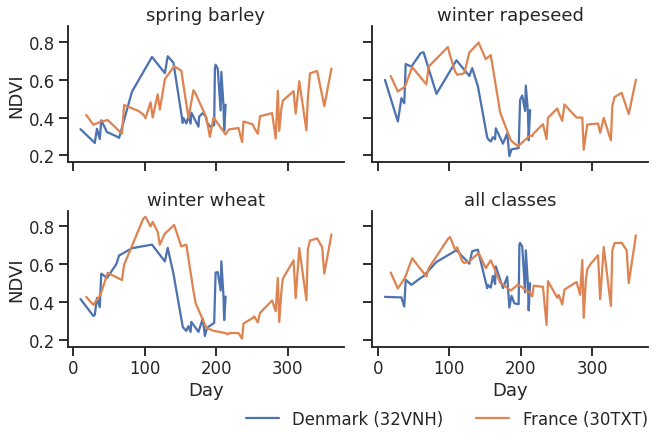

In [89]:
sns.set_theme()
sns.set_style('ticks')
sns.set_context('talk')
sns.despine()
#palette = sns.color_palette("mako_r", 2)
palette = sns.color_palette(n_colors=2)


g = sns.FacetGrid(big_df, col='class', col_wrap=2, height=3.0, aspect=1.6, despine=True, legend_out=True)
g.map_dataframe(sns.lineplot, x='day', y='ndvi', hue='country', ci=None, palette=palette)

g.set_axis_labels('Day', 'NDVI')
#g.set(ylim=(0.0, 1.0))
g.set_titles(col_template="{col_name}")
g.add_legend(bbox_to_anchor=(0.61, -0.001), ncol=2)
g.tight_layout()
g.savefig('intro_figure.pdf')



# GDD

In [2]:
dataset_dk = PixelSetData('/media/data/timematch_data', 'denmark/32VNH/2017', classes=classes)
dataset_fr = PixelSetData('/media/data/timematch_data', 'france/30TXT/2017', classes=classes)

gdd_dk = dataset_dk[0]['gdd']
doy_dk = dataset_dk[0]['positions']
gdd_fr = dataset_fr[0]['gdd']
doy_fr = dataset_fr[0]['positions']

NameError: name 'classes' is not defined

In [11]:
src_tile = '32VNH'
trg_tile = '30TXT'

tiles = [('AT1', '33UVP'), ('DK1', '32VNH'),  ('FR1', '30TXT'), ('FR2', '31TCJ')]
#tiles = [('DK1', '32VNH'),  ('FR1', '30TXT'), ('FR2', '31TCJ')]

def calc_gdd(t_min, t_max, t_base=0, t_cap=30, gdd_cap=3000):
    gdd = np.maximum((np.minimum(t_max, t_cap) + np.maximum(t_min, t_base)) / 2 - t_base, 0)
    return gdd

crop = 'corn'
#gdd_dict = {}
#pos_dict = {}

data = []
t_base = 0
for name, tile in tiles:    
    #pos = np.load(f'weather_data/{tile}_pos.npy')
    #pos = np.arange(365)
    gdd = np.load(f'weather_data/{tile}_gdd.npy')
    gdd = gdd.mean(axis=0)
    #tmin_tmax = np.load(f'weather_data/{tile}_{crop}_tmin_tmax.npy')
    #t_min, t_max = tmin_tmax[:, 0], tmin_tmax[:, 1]

    #gdd = np.maximum(
    #    (t_max + t_min) / 2 - t_base, 0
    #)
    
    #gdd = np.cumsum(gdd, axis=0)
    #mask = gdd > 3000
    #gdd[mask] = np.arange(np.sum(mask)) + 3000
   # gdd_dict[tile] = gdd
    #pos_dict[tile] = pos
    
    #plt.plot(gdd, label=tile)
    

    #print(gdd.min())
    #print(gdd.max())
    
    #for x in gdd:
    for doy, v in enumerate(gdd):
        data.append((name, doy, v))
        
            


#doy = np.arange(365)
    
#for tile, gdd in data.items():
#    print(gdd.shape)
#    plt.plot(doy, gdd.mean(0), label=tile)

    
#plt.legend()
#plt.show()




In [12]:
import pandas as pd

stuff = pd.DataFrame(data, columns=['tile', 'doy', 'gdd'])


<Figure size 432x288 with 0 Axes>

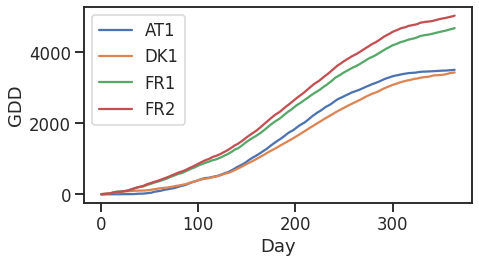

In [17]:
import seaborn as sns

sns.set_theme()
sns.set_style('ticks')
sns.set_context('talk')
sns.despine()

#g = sns.FacetGrid(stuff, col='class', col_wrap=2, height=3.0, aspect=1.6, despine=True, legend_out=True)
#g.map_dataframe(sns.lineplot, x='day', y='ndvi', hue='country', ci=None, palette=palette)


plt.figure(figsize=(7, 4))
g = sns.lineplot(data=stuff, x='doy', y='gdd', hue='tile')
g.set(xlabel='Day', ylabel='GDD')

#ax2 = g.twinx()
#ax2.plot(np.arange(365), np.arange(365), label='default')
#ax2.set_ylabel('Calendar time')


#g.set(ylim=(0.0, 1.0))
#g.set_titles(col_template="{col_name}")
#g.add_legend(bbox_to_anchor=(0.61, -0.001), ncol=2)
plt.legend(title='')
plt.tight_layout()
plt.savefig('gdd.pdf')


0.8
[ 18  28  38  48  58  68  71  88  98 101 108 111 118 121 128 141 151 158
 168 171 178 183 186 196 213 216 218 231 233 238 243 251 253 258 261 278
 283 286 288 291 293 308 311 316 318 326 328 331 341 348 351 353 361]
[14, 43, 66, 82, 95, 106, 118, 132, 142, 147, 151, 155, 158, 161, 168, 178, 190, 200, 208, 215, 222, 228, 234, 248, 264, 273, 280, 292, 301, 313, 334, 355, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364]


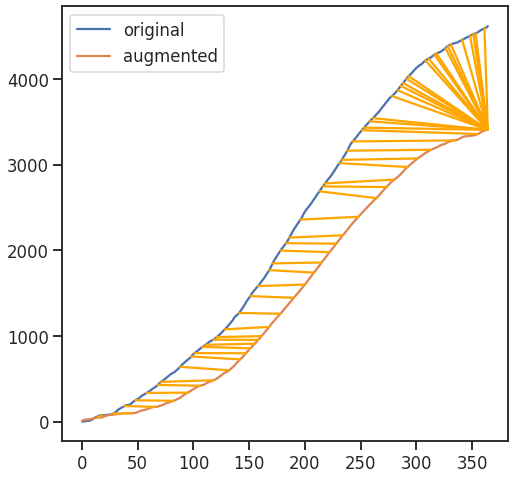

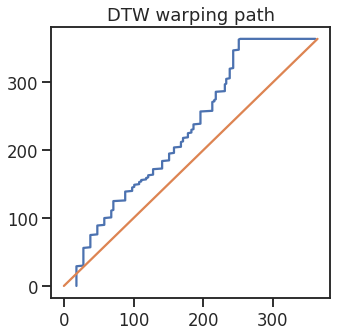

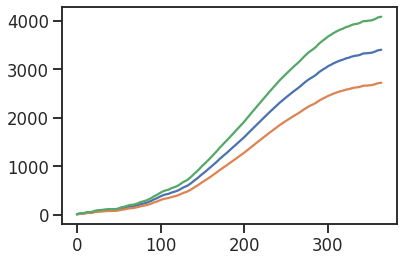

In [126]:
from tslearn.metrics import dtw_path, lcss_path, dtw_path_limited_warping_length

tile = '30TXT'
alpha = random.uniform(1.1, 1.2)
alpha = 0.8

gdd_org = gdd_dict[tile]
pos_org = pos_dict[tile]
gdd_aug = alpha*gdd_org
gdd_aug = gdd_dict['32VNH']


path, dist = dtw_path(gdd_org[pos_org], gdd_aug)#, global_constraint="sakoe_chiba", sakoe_chiba_radius=90)


#path, dist = dtw_path_limited_warping_length(gdd_org[pos_org], gdd_aug, max_length=len(pos_org))#, global_constraint="sakoe_chiba", sakoe_chiba_radius=90)



#path, dist = dtw_path(gdd_org[pos_org], gdd_aug, global_constraint="itakura", itakura_max_slope=30)
#path, dist = lcss_path(gdd_org, gdd_aug, eps=1.5)#, global_constraint="sakoe_chiba", sakoe_chiba_radius=90)
path = np.array(path)

# Plot original time series

plt.figure(figsize=(8,8))
plt.plot(np.arange(365), gdd_org, label='original')
plt.plot(np.arange(365), gdd_aug, label='augmented')

prev = None


new_pos = []
for i, src_pos in enumerate(pos_org):
    maps_to = path[path[:, 0] == i, 1]
    
    if alpha < 1.0:
        trg_pos = maps_to[-1] # positive shift bias
    else:
        trg_pos = maps_to[0]  # negative shift bias
    
    trg_pos = np.mean(maps_to).astype(int)
    #print(src_pos, maps_to)
    #continue
    
    #if src_pos in pos_org:
    #    plt.plot([src_pos, trg_pos], [gdd_org[src_pos], gdd_aug[trg_pos]], color='orange')
    plt.plot([src_pos, trg_pos], [gdd_org[src_pos], gdd_aug[trg_pos]], color='orange')
    new_pos.append(trg_pos)
print(alpha)
print(pos_org)
print(new_pos)

#prev = None
#for src_pos, trg_pos in path:
    #print(src_pos, trg_pos)
    
    #if src_pos == prev:
     #   continue
    
    #if src_pos in pos_org:
    #    plt.plot([src_pos, trg_pos], [gdd_org[src_pos], gdd_aug[trg_pos]], color='orange')
   # plt.plot([pos_org[src_pos], trg_pos], [gdd_org[pos_org][src_pos], gdd_aug[trg_pos]], color='orange')
  #  prev = src_pos

plt.legend()
plt.show()


plt.figure(figsize=(5,5))
plt.title('DTW warping path')
plt.plot(pos_org[path[:, 0]], path[:, 1])
plt.plot(np.arange(365), np.arange(365), label='identity')
plt.show()
#plt.xlabel('DK')
#plt.ylabel('FR')


tile = '32VNH'
plt.plot(np.arange(365), gdd_dict[tile])
plt.plot(np.arange(365), 0.8*gdd_dict[tile])
plt.plot(np.arange(365), 1.2*gdd_dict[tile])


In [124]:
from tslearn.metrics import dtw_path, lcss_path, dtw_path_limited_warping_length

tile = '30TXT'
alpha = random.uniform(1.1, 1.2)
alpha = 0.8

pos_org = pos_dict[tile]
gdd_org = gdd_dict[tile][pos_org]
gdd_aug = alpha*gdd_org

path, dist = dtw_path_limited_warping_length(gdd_org, gdd_aug, max_length=100)

print(path)


[(0, 0), (1, 1), (2, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (7, 9), (7, 10), (8, 11), (8, 12), (9, 13), (10, 14), (11, 14), (12, 15), (13, 15), (14, 16), (15, 17), (16, 18), (16, 19), (17, 20), (17, 21), (18, 22), (19, 23), (20, 23), (21, 24), (22, 25), (22, 26), (23, 27), (23, 28), (24, 29), (24, 30), (25, 31), (25, 32), (26, 33), (26, 34), (27, 35), (28, 36), (29, 37), (29, 38), (29, 39), (30, 40), (31, 41), (31, 42), (32, 43), (32, 44), (33, 45), (33, 46), (33, 47), (34, 48), (34, 49), (34, 50), (34, 51), (35, 52), (36, 52), (37, 52), (38, 52), (39, 52), (40, 52), (41, 52), (42, 52), (43, 52), (44, 52), (45, 52), (46, 52), (47, 52), (48, 52), (49, 52), (50, 52), (51, 52), (52, 52)]


In [127]:
gdd_dict['32VNH']

array([   8.29095386,   14.18956012,   16.76158304,   21.33347105,
         24.29452493,   24.29452493,   24.29452493,   26.8496997 ,
         28.36554382,   31.57484445,   35.18248173,   40.0495046 ,
         43.55229673,   45.11168231,   46.42937958,   46.42937958,
         46.42937958,   46.42937958,   49.43444445,   54.66196182,
         60.63746118,   65.82189663,   69.36491853,   72.10197142,
         74.64770063,   76.9447785 ,   77.638265  ,   78.71003321,
         80.13591229,   82.08980336,   84.87799511,   86.54300506,
         87.81830473,   89.12397903,   90.86642654,   93.48681609,
         95.33165122,   96.23446338,   96.23446338,   96.23446338,
         96.23446338,   96.23446338,   96.47008276,   96.47008276,
         96.47008276,   96.47008276,   96.67417366,   98.96167611,
        102.75434336,  105.0663463 ,  110.144533  ,  115.79231509,
        121.67902825,  127.44795419,  130.8511709 ,  132.50435768,
        133.86681019,  138.89827861,  145.1211506 ,  150.09614

# ShiftAug with GDD

/home/jnyborg/miniconda3/envs/ml/lib/python3.8/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


8528.735197112543
42.08
44.29106029106029
(481, 2)


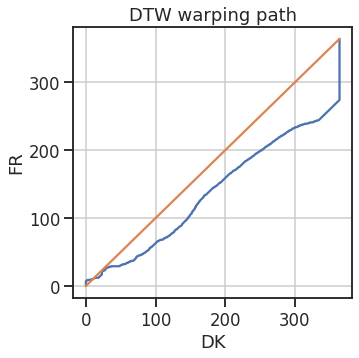

In [12]:
from tslearn.metrics import dtw_path

#path, dist = dtw_path(gdd_dk, gdd_fr)

gdd_src, gdd_trg = gdd_dict['32VNH'], gdd_dict['30TXT']
pos_src, pos_trg = pos_dict['32VNH'], pos_dict['30TXT']

path, dist = dtw_path(gdd_src, gdd_trg, global_constraint="sakoe_chiba", sakoe_chiba_radius=90)

print(dist)

path = [(src, trg) for src, trg in path]
path = np.array(path)

print(np.abs(np.diff(path[100:200])).mean())
print(np.abs(np.diff(path)).mean())

print(path.shape)
plt.figure(figsize=(5,5))
plt.title('DTW warping path')

plt.plot(path[:, 0], path[:, 1])
plt.plot(np.arange(365), np.arange(365), label='identity')
plt.xlabel('DK')
plt.ylabel('FR')
plt.grid()

# NDVI and GDD

Denmark
[  4.  12.  15.  18.  23.  24.  32.  45.  49.  60.  72.  86. 112. 116.
 132. 135. 142. 147. 155. 158. 188. 192. 200. 205. 209. 213. 217. 244.
 247. 254. 257. 264. 267. 274. 286. 299. 304. 307. 314. 319. 322. 323.
 326. 327. 327. 332. 333. 339.]
Mid-west France
[  7.   9.  18.  24.  33.  42.  46.  64.  76.  80.  87.  89.  95.  98.
 107. 126. 146. 158. 176. 184. 199. 208. 214. 235. 268. 274. 278. 301.
 305. 316. 327. 340. 343. 350. 354. 380. 386. 391. 395. 400. 403. 421.
 423. 428. 429. 436. 438. 440. 445. 450. 452. 453. 459.]
Austria
[  0.   0.   1.   1.   4.   8.  24.  30.  48.  50.  54.  65.  69.  98.
 104. 115. 121. 134. 156. 165. 172. 176. 182. 191. 195. 210. 213. 221.
 232. 236. 251. 260. 269. 273. 289. 302. 307. 311. 313. 324. 329. 336.
 347. 351. 352. 354. 358. 363. 364.]
3403.8076162266607
4617.2485581351075
3670.095062822126


<Figure size 432x288 with 0 Axes>

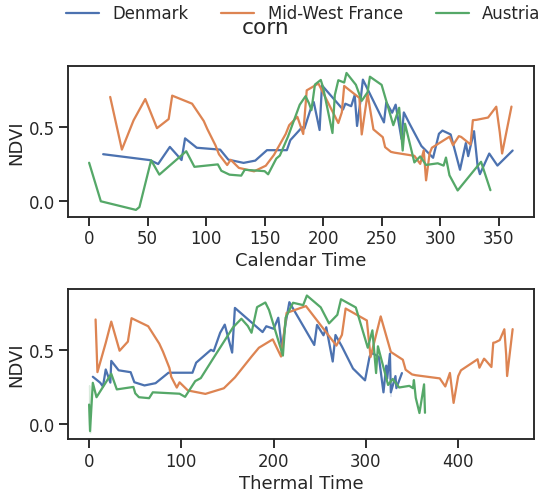

In [9]:
sns.set_theme()
sns.set_style('ticks')
sns.set_context('talk')
sns.despine()

tiles = [('Denmark', '32VNH'), ('Mid-west France', '30TXT'), ('Austria', '33UVP')]


data = []

gdd_cap = 10000
max_pos = 0
crop_type = 'corn'


fig, ax =plt.subplots(2, 1, figsize=(8,7))

fig.suptitle(f'{crop_type}') # or plt.suptitle('Main title')

t_base, t_cap = 0, 30

do_limit = False

limit = 90


for name, tile in tiles:
    #gdd = np.load(f'weather_data/{tile}_{crop_type}_gdd.npy')
    ndvi = np.load(f'weather_data/{tile}_{crop_type}_ndvi.npy')
    pos = np.load(f'weather_data/{tile}_{crop_type}_pos.npy')
    
    tmin_tmax = np.load(f'weather_data/{tile}_{crop_type}_tmin_tmax.npy')
    t_min, t_max = tmin_tmax[:, 0], tmin_tmax[:, 1]
    
    
    
    #gdd = np.maximum(
    #    (np.minimum(t_max, t_cap) + np.maximum(t_min, t_base)) / 2 - t_base, 0
    #)
    gdd = np.maximum(
        (t_max + t_min) / 2 - t_base, 0
    )
    
    if do_limit:
        gdd[:limit] = 0
    
    gdd = np.cumsum(gdd, axis=0)
    gdd = gdd[pos]
    
    gdd = gdd // 10
    print(name)
    print(gdd)


    
    g = sns.lineplot(x=gdd[gdd < gdd_cap], y=ndvi[gdd < gdd_cap], label=name, ax=ax[1], legend=False)
    g.set(xlabel='Thermal Time', ylabel='NDVI')
    
    
    max_pos = max(max_pos, pos[gdd < gdd_cap][-1])

for name, tile in tiles:
    #gdd = np.load(f'weather_data/{tile}_{crop_type}_gdd.npy')
    ndvi = np.load(f'weather_data/{tile}_{crop_type}_ndvi.npy')
    pos = np.load(f'weather_data/{tile}_{crop_type}_pos.npy')
    
    tmin_tmax = np.load(f'weather_data/{tile}_{crop_type}_tmin_tmax.npy')
    t_min, t_max = tmin_tmax[:, 0], tmin_tmax[:, 1]

    
    #gdd = np.maximum(
    #    (np.minimum(t_max, t_cap) + np.maximum(t_min, t_base)) / 2 - t_base, 0
    #)
    
    gdd = np.maximum(
        (t_max + t_min) / 2 - t_base, 0
    )
    if do_limit:
        gdd[:limit] = 0
    gdd = np.cumsum(gdd, axis=0)
    print(gdd.max())
    gdd = gdd[pos]
    
    
    
    g = sns.lineplot(x=pos[gdd < gdd_cap], y=ndvi[gdd < gdd_cap], label=name, ax=ax[0], legend=False)
    #g = sns.lineplot(x=pos[pos < max_pos], y=ndvi[pos < max_pos], label=name)
    g.set(xlabel='Calendar Time', ylabel='NDVI')
    


#fig.legend(['Denmark', 'Mid-West France', 'Austria'], loc=(0.1, -0.004), ncol=3, frameon=False)
fig.legend(['Denmark', 'Mid-West France', 'Austria'], loc=(0.11, 0.94), ncol=3, frameon=False)
#ax[0].set_ylim(0, 1)
#ax[1].set_ylim(0, 1)
#fig.suptitle('Winter Wheat')

plt.tight_layout()

plt.savefig('intro_figure.pdf', bbox_inches='tight')
plt.show()



#palette = sns.color_palette("mako_r", 2)
#palette = sns.color_palette(n_colors=2)


#g = sns.FacetGrid(big_df, col='class', col_wrap=2, height=3.0, aspect=1.6, despine=True, legend_out=True)
#g.map_dataframe(sns.lineplot, x='day', y='ndvi', hue='country', ci=None, palette=palette)

#g.set_axis_labels('Day', 'NDVI')

#g.set_titles(col_template="{col_name}")
#g.add_legend(bbox_to_anchor=(0.61, -0.001), ncol=2)
#g.tight_layout()
#g.savefig('intro_figure.pdf')

# Aug


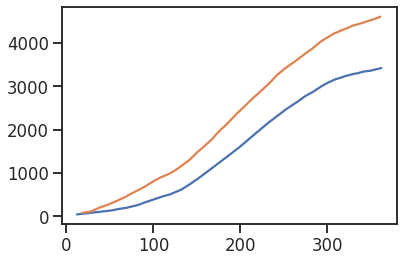

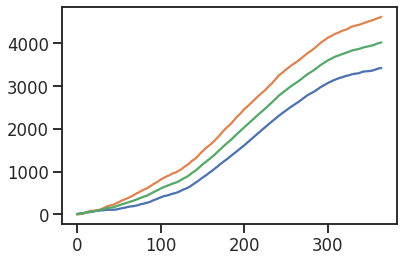

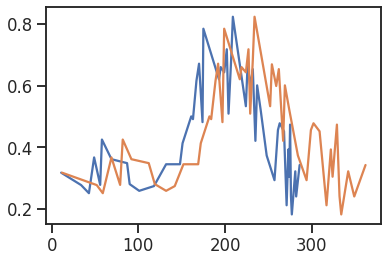

In [75]:
from tslearn.metrics import dtw_path

sns.set_theme()
sns.set_style('ticks')
sns.set_context('talk')
sns.despine()

tiles = [('Denmark', '32VNH'), ('Mid-west France', '30TXT')]


data = []

gdd_cap = 10000
max_pos = 0
crop_type = 'corn'





t_base, t_cap = 0, 30

do_limit = False

limit = 150


ndvis = []
poss = []
gdds = []

for name, tile in tiles:
    ndvi = np.load(f'weather_data/{tile}_{crop_type}_ndvi.npy')
    pos = np.load(f'weather_data/{tile}_{crop_type}_pos.npy')
    
    tmin_tmax = np.load(f'weather_data/{tile}_{crop_type}_tmin_tmax.npy')
    t_min, t_max = tmin_tmax[:, 0], tmin_tmax[:, 1]
    
    
    
    gdd = np.maximum(
        (np.minimum(t_max, t_cap) + np.maximum(t_min, t_base)) / 2 - t_base, 0
    )
    
    if do_limit:
        gdd[:limit] = 0
    
    gdd = np.cumsum(gdd, axis=0)
    
    plt.plot(pos, gdd[pos])
    
    ndvis.append(ndvi)
    poss.append(pos)
    gdds.append(gdd)
    
plt.show()
    
alpha = random.random()
alpha = 0.5

#ndvi2 = alpha * ndvis[0] + (1-alpha) * ndvis[1]
#gdd2 = alpha * gdds[0] + (1-alpha) * gdds[1]
gdd2 = alpha * gdds[0] + (1-alpha) * gdds[1]

plt.plot(np.arange(365), gdds[0])
plt.plot(np.arange(365), gdds[1])
plt.plot(np.arange(365), gdd2)
plt.show()

path, dist = dtw_path(gdds[0], gdd2)

new_pos = []

from collections import defaultdict

warp_dict = defaultdict(list)
for src, trg in path:
    warp_dict[src].append(trg)
    
warp_dict = {k: int(np.mean(v)) for k, v in warp_dict.items()}
    
new_pos = [warp_dict[x] for x in poss[0]]
    

plt.plot(new_pos, ndvis[0])
plt.plot(poss[0], ndvis[0])
plt.show()


In [48]:
from datetime import datetime
for doy, gdd in enumerate(gdd_dk):
    date = datetime.strptime(f'2017 {doy+1}', '%Y %j')

    print(date.date(), doy)
    
    
def calc_gdd(t_min, t_max, t_base=0, t_cap=30, gdd_cap=3000):
    gdd = np.maximum((np.minimum(t_max, t_cap) + np.maximum(t_min, t_base)) / 2 - t_base, 0)
    
    #gdd = np.maximum((t_max + t_min)/2 - t_base, 0)
    
    
    gdd = np.cumsum(gdd, axis=0)
    gdd[gdd > gdd_cap] = gdd_cap
    
    return gdd


gdds_dk = []
gdds_fr = []

for base in [0, 5, 10]:
    gdd_dk = calc_gdd(dk_t_min, dk_t_max, t_base=base)
    gdd_fr = calc_gdd(fr_t_min, fr_t_max, t_base=base)
    
    gdd_dk = gdd_dk.reshape(365, -1)
    mask = (gdd_dk != 0.0).any(axis=0)
    gdd_dk = gdd_dk[:, mask]
    gdd_dk = gdd_dk.mean(axis=1)
    plt.plot(gdd_dk, label=f'DK {base}', color='red')

    gdd_fr = gdd_fr.mean((1, 2))
    gdds_dk.append(gdd_dk)
    gdds_fr.append(gdd_fr)
    
    plt.plot(gdd_fr, label=f'FR {base}', color='blue')
    
gdds_dk = np.array(gdds_dk).T
gdds_fr = np.array(gdds_fr).T
plt.legend()
plt.show()

    
    
gdd_dk = calc_gdd(dk_t_min, dk_t_max)
gdd_fr = calc_gdd(fr_t_min, fr_t_max)

print(gdd_dk.shape)
for i in range(gdd_dk.shape[1]):
    for j in range(gdd_dk.shape[2]):
        plt.plot(gdd_dk[:, i, j])

for i in range(gdd_fr.shape[1]):
    for j in range(gdd_fr.shape[2]):
        plt.plot(gdd_fr[:, i, j])
plt.show()


gdd_dk = gdd_dk.reshape(365, -1)
mask = (gdd_dk != 0.0).any(axis=0)
gdd_dk = gdd_dk[:, mask]
gdd_dk = gdd_dk.mean(axis=1)

gdd_fr = gdd_fr.mean((1, 2))

#gdd_dk = gdd_dk[:, -1, 0]  # gdd_dk contains ocean on the right - top left should be OK
#gdd_fr = gdd_fr[:, 0, 0]
plt.plot(gdd_dk)
plt.plot(gdd_fr)
plt.show()

#gdd_dk = gdd_dk.mean((1, 2))

doy_dk = doy_fr = np.arange(365)

normalize = False
if normalize:
    gdd_dk = (gdd_dk) / gdd_dk.max()
    gdd_fr = (gdd_fr) / gdd_fr.max()
    

2017-01-01 0
2017-01-02 1
2017-01-03 2
2017-01-04 3
2017-01-05 4
2017-01-06 5
2017-01-07 6
2017-01-08 7
2017-01-09 8
2017-01-10 9
2017-01-11 10
2017-01-12 11
2017-01-13 12
2017-01-14 13
2017-01-15 14
2017-01-16 15
2017-01-17 16
2017-01-18 17
2017-01-19 18
2017-01-20 19
2017-01-21 20
2017-01-22 21
2017-01-23 22
2017-01-24 23
2017-01-25 24
2017-01-26 25
2017-01-27 26
2017-01-28 27
2017-01-29 28
2017-01-30 29
2017-01-31 30
2017-02-01 31
2017-02-02 32
2017-02-03 33
2017-02-04 34
2017-02-05 35
2017-02-06 36
2017-02-07 37
2017-02-08 38
2017-02-09 39
2017-02-10 40
2017-02-11 41
2017-02-12 42
2017-02-13 43
2017-02-14 44
2017-02-15 45
2017-02-16 46
2017-02-17 47
2017-02-18 48
2017-02-19 49
2017-02-20 50
2017-02-21 51
2017-02-22 52
2017-02-23 53
2017-02-24 54
2017-02-25 55
2017-02-26 56
2017-02-27 57
2017-02-28 58
2017-03-01 59
2017-03-02 60
2017-03-03 61
2017-03-04 62
2017-03-05 63
2017-03-06 64
2017-03-07 65
2017-03-08 66
2017-03-09 67
2017-03-10 68
2017-03-11 69
2017-03-12 70
2017-03-13 71
20

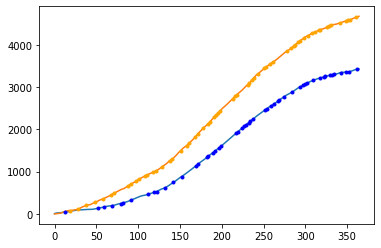

[ 0.  2.  3.  4.  5.  6.  9. 10. 12. 14. 17. 22. 23. 26. 27. 28. 29. 31.
 38. 40. 41. 42. 43. 44. 49. 51. 53. 55. 57. 60. 61. 63. 64. 65. 66. 67.
 68.]
[ 1.  2.  4.  5.  7.  9. 13. 14. 15. 16. 17. 18. 19. 20. 22. 25. 29. 32.
 33. 36. 37. 40. 42. 43. 45. 46. 47. 48. 54. 55. 56. 61. 63. 64. 66. 68.
 69. 70. 71. 77. 78. 79. 80. 81. 83. 84. 85. 86. 87. 88. 89. 90. 91. 93.]
[  45  136  166  197  246  260  334  468  506  529  616  743  883 1138
 1185 1337 1367 1444 1491 1567 1598 1906 1939 2024 2073 2108 2157 2189
 2236 2462 2491 2559 2596 2664 2695 2766 2880 3011 3041 3065 3096 3159
 3209 3244 3252 3280 3294 3297 3342 3357 3363 3421]


In [112]:
dk_pos = [12, 52, 59, 69, 79, 82, 92, 112, 119, 122, 132, 142, 152, 169, 172, 182, 184, 189, 192, 197, 199, 217, 219, 224, 227, 229, 232, 234, 237, 252, 254, 259, 262, 267, 269, 274, 284, 294, 297, 299, 302, 309, 317, 322, 324, 329, 332, 334, 342, 349, 352, 362]
fr_pos = [18, 28, 38, 48, 58, 68, 71, 88, 91, 98, 101, 108, 111, 118, 121, 128, 138, 141, 151, 158, 161, 168, 171, 178, 183, 186, 191, 193, 196, 198, 213, 216, 218, 231, 233, 236, 238, 243, 251, 253, 258, 261, 278, 283, 286, 288, 291, 293, 298, 303, 308, 311, 316, 318, 326, 328, 331, 341, 348, 351, 353, 361]
n = np.random.normal(0, gdd_dk.std(), gdd_dk.size) * 0.05
#n = random.uniform(-50, 50)
#print(n)


#plt.plot(gdd_dk + n)
plt.plot(gdd_dk)
plt.plot(gdd_fr)
plt.plot(dk_pos, gdd_dk[dk_pos], '.', color='blue');
plt.plot(fr_pos, gdd_fr[fr_pos], '.', color='orange');

plt.show()



print(np.unique(gdd_dk[dk_pos] // 50))
print(np.unique(gdd_fr[fr_pos] // 50))


np.histogram(np.arange(365), bins=dk_pos)

print(gdd_dk[dk_pos].astype(int))


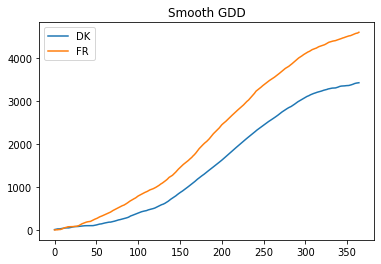

distance between peaks 30


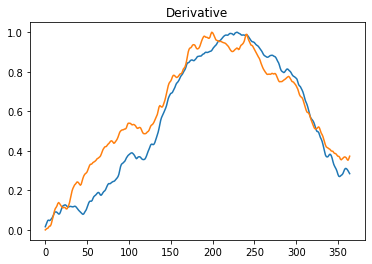

distance between peaks 30


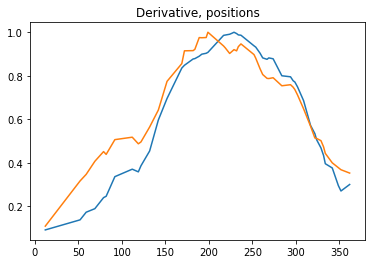

In [7]:
from scipy.signal import savgol_filter
import scipy.fftpack
from scipy import optimize

def sin_func(x, a, b):
    return a * np.sin(b * x)

def expoweight(theta,beta=0.9):
    v0 = 0
    vs = np.zeros(theta.shape)
    T = theta.shape[0]
    for t in range(1,T+1):
        vt = beta*v0+(1-beta)*theta[t-1]
        vs[t-1] = vt
        v0=vt
    return vs

def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = np.array(tt)
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = np.std(yy) * 2.**0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A * np.sin(w*t + p) + c
    popt, pcov = optimize.curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*np.pi)
    fitfunc = lambda t: A * np.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": np.max(pcov), "rawres": (guess,popt,pcov)}

positions = [12, 52, 59, 69, 79, 82, 92, 112, 119, 122, 132, 142, 152, 169, 172, 182, 184, 189, 192, 197, 199, 217, 219, 224, 227, 229, 232, 234, 237, 252, 254, 259, 262, 267, 269, 274, 284, 294, 297, 299, 302, 309, 317, 322, 324, 329, 332, 334, 342, 349, 352, 362]
smooth=True
if smooth:
    #smooth_gdd_dk = np.poly1d(np.polyfit(doy_dk, gdd_dk, 3))(doy_dk)
    #smooth_gdd_fr = np.poly1d(np.polyfit(doy_fr, gdd_fr, 3))(doy_fr)
    
    smooth_gdd_dk = gdd_dk
    smooth_gdd_fr = gdd_fr
    #smooth_gdd_dk = expoweight(gdd_dk, beta=0.99)
    #smooth_gdd_fr = expoweight(gdd_fr, beta=0.99)
    
    #smooth_gdd_dk = fit_sin(doy_dk, gdd_dk)['fitfunc'](doy_dk)
    #smooth_gdd_fr = fit_sin(doy_fr, gdd_fr)['fitfunc'](doy_fr)
    
    plt.title('Smooth GDD')
    plt.plot(doy_dk, smooth_gdd_dk, label='DK')
    plt.plot(doy_fr, smooth_gdd_fr, label='FR')
    plt.legend()
    plt.show() 
    plt.title('Derivative')
    
    grad_dk = np.gradient(smooth_gdd_dk)
    grad_fr = np.gradient(smooth_gdd_fr)
    grad_dk = expoweight(grad_dk, beta=0.95)
    grad_fr = expoweight(grad_fr, beta=0.95)
    
    grad_dk = grad_dk / grad_dk.max()
    grad_fr = grad_fr / grad_fr.max()
    print('distance between peaks', np.abs(grad_dk.argmax() - grad_fr.argmax()))
    plt.plot(doy_dk, grad_dk)
    plt.plot(doy_fr, grad_fr)
    plt.show()
    
    plt.title('Derivative, positions')
    plt.plot(positions, grad_dk[positions])
    plt.plot(positions, grad_fr[positions])
    print('distance between peaks', np.abs(positions[grad_dk[positions].argmax()] - positions[grad_fr[positions].argmax()]))
    plt.show()
else:
    plt.title('GDD')
    plt.plot(doy_dk, gdd_dk / gdd_fr.max(), label='DK')
    plt.plot(doy_fr, gdd_fr / gdd_fr.max(), label='FR')
    plt.legend()
    plt.show() 
    
    grad_dk = np.gradient(gdd_dk)
    grad_fr = np.gradient(gdd_fr)
    
    grad_dk = grad_dk / grad_dk.max()
    grad_fr = grad_fr / grad_fr.max()

    plt.title('Derivative')
    plt.plot(doy_dk, grad_dk)
    plt.plot(doy_fr, grad_fr)
    plt.show()
    



#grad_dk = savgol_filter(grad_dk, 191, 2) # window size 51, polynomial order 3
#grad_fr = savgol_filter(grad_fr, 191, 2) # window size 51, polynomial order 3


12696.303818319375
45.82
48.39112050739958
(473, 2)


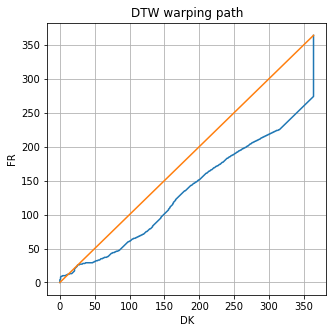

In [41]:
from tslearn.metrics import dtw_path

#path, dist = dtw_path(gdd_dk, gdd_fr)
path, dist = dtw_path(smooth_gdd_dk, smooth_gdd_fr, global_constraint="sakoe_chiba", sakoe_chiba_radius=90)

print(dist)

path = [(doy_dk[src], doy_fr[trg]) for src, trg in path]
path = np.array(path)

print(np.abs(np.diff(path[100:200])).mean())
print(np.abs(np.diff(path)).mean())

print(path.shape)
plt.figure(figsize=(5,5))
plt.title('DTW warping path')

plt.plot(path[:, 0], path[:, 1])
plt.plot(np.arange(365), np.arange(365), label='identity')
plt.xlabel('DK')
plt.ylabel('FR')
plt.grid()


In [93]:
print('shift', np.abs(path[:, 0] - path[:, 1]))

doy_dk = dataset_dk[0]['positions']

new_src_doy = []
for src_doy, index, freq in zip(*np.unique(path[:, 0], return_counts=True, return_index=True)):
    if src_doy not in doy_dk:
        continue
    if freq > 1:
        trg_doy = int(np.mean(path[index:index+freq, 1]))
    else:
        trg_doy = path[index, 1]
    
    new_src_doy.append(trg_doy)

print(np.array(new_src_doy))

[[  0   0]
 [  0   0]
 [  0   0]
 ...
 [364 364]
 [364 364]
 [364 364]]
shift [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0